In [ ]:
# Chapter3. 분류에서 사용되는 평가 지표를 다룬다

# 분류의 성능 평가 지표 종류
# 정확도(Accuracy)
# 오차행렬(confusion matrix)
# 정밀도(Precision)
# F1 스코어
# ROU AUC


# 데이터 불러오기
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

titanic_df = pd.read_csv('/content/drive/My Drive/titanic_train.csv')


Mounted at /content/drive


In [ ]:
# 정확도(accuracy)
# 정확도는 실제 데이터에서 예측 데이터가 얼마나 같은지를 판단하는 지표
# 이진 분류의 경우 정확도는 데이터의 구성에 따라 모델의 성능이 왜곡될 수 있다

In [ ]:
# 정확도 지표가 왜 ML 모델의 성능을 왜곡하는지 예제로 살펴보기

from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    
    # fit() 메서드는 아무것도 학습하지 않음
    def fit(self, x, y = None):
        pass

    # predict() 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측한다
    def predict(self, x):
        pred = np.zeros((x.shape[0], 1))
        for i in range(x.shape[0]):
            if x['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1

        return pred



In [ ]:
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 피처 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩 수행.
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [ ]:
# 데이터를 가공하고 나서 위 Classifier를 이용해 학습/예측/평가 적용하기
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis = 1)
X_trainic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test= train_test_split(X_titanic_df, y_titanic_df, test_size = 0.2, random_state = 0)

# 위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)
mypredictions = myclf.predict(X_test)
print("DUmmmy Classifier의 정확도는: {0:.4f}".format(accuracy_score(y_test, mypredictions)))

# 정확도는 불균형한 레이블 값 분포에서 ML 모델의 성능을 판단할 경우, 적절항 평가 지표가 아니다


DUmmmy Classifier의 정확도는: 0.7877


In [ ]:
# 불균형한 데이터 세트와 Dummy Classifer를 생성
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self, x, y):
        pass

    # 입력값으로 들어오는 x 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self, x):
        return np.zeros((len(x), 1), dtype=bool)
    
# 사이킷런의 내장 데이터 세트인 load_digits()를 이용해 MNIST 데이터 로딩
digits = load_digits()

y = (digits.target == 7).astype(int)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

(1797,)


In [ ]:
# 불균형한 데이터로 생성한 y_test의 데이터 분포도를 확인하고, MyFakeClassifier를 이용해 예측과 평가 수행

print("레이블 테스트 세트 크기:", y_test.shape)
print("테스트 세트 레이블 0과 1의 분포도")
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print("모든 예측을 0을 하여도 정확도는:{:.3f}".format(accuracy_score(y_test, fakepred)))

# 정확도가 가지는 분류 평가 지표로서의 이러한 한계점을 극복하기 위해 여러 가지 분류의 지표와 함께 ML 모델 성능을 평가해야 한다
# 이를 오차 행렬을 이용해 평가한다

레이블 테스트 세트 크기: (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0을 하여도 정확도는:0.900


In [ ]:
# 오차 행렬
# 학습된 분류 모델이 예측을 수행하면서 얼마나 헷갈리고 있는지 함께 보여주는 지표
# 4분면 행렬에서 실제 레이블 클래스 값과 예측 레이블 클래스 값이 어떠한 유형을 가지고 있는지 매핑
# TN, TP, FN, FP 형태로 오차 행렬의 4분면을 채울 수 있다

# TN은 예측값을 Negative 값 0으로 예측했고, 실제 값 역시 Negative 값 0
# FP는 예측값을 Positive 값 1로 예측했고, 실제 값은 Negative 값 0
# FN은 예측값을 Negative 값 0으로 예측했고, 실제 값은 Positive 값 1
# TP는 예측값을 Positive 값 1로 에측했고, 실제 값 역시 Positive 값 1    

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

# TN(실제: 7이 아닌 Digit) FP (실제: 7이 아닌 Digit)
# FN(실제: 7인 Digit) TP (실제: 7인 DIgit)

# 정확도: (TN + TP) / (TN + FP + FN + TP)
# 예측 결과와 실제 값이 동일한 건수 / 전체 데이터 건수

# 정확도 지표는 비대칭한 데이터 세트에서 Positive에 대한 예측 정확도를 판단하지 못한 채
# Negative에 대한 예측 정화도만으로도 분류의 정확도가 매우 높게 나타나는 수치적인 판단 오류를 일으킨다



array([[405,   0],
       [ 45,   0]])

In [ ]:
# 정밀도와 재현율

# 정밀도: TP / (FP + TP) 
# 예측을 Positive로 한 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율
# 양성 예측도라고 불린다
# 스펨 매일 확인

# 재현율: TP / (FN + TP)
# 실제 값이 Positive로 한 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율
# 민감도 또는 TPR(True Positive Rate)라고 불린다
# 암 판단 및 보험 금융 사기 적발 모델에 중요하게 사용


In [ ]:
# get_clf_eval() 함수 정의
from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix

def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy , precision ,recall))


In [ ]:
# 로지스틱 회귀 기반으로 타이타닉 생존자를 예측하고 평가를 수행
# LogisticRegression 객체의 생성 인자로 입력되는 solver = 'liblinear'는 로지스틱 회귀의 최적화 알고리즘 유형을 저장하는 것
# 작은 데이터 세트의 이진 분류인 경우 solver는 liblinear가 약간 성능이 좋은 경향이 있다
# 반면 solver의 기본값은 lbfgs이며 데이터 세트가 상대적으로 크고 다중 분류인 경우 적합하다

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할

titanic_df = pd.read_csv('/content/drive/My Drive/titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis = 1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size = 0.20, random_state=11)

lr_clf = LogisticRegression(solver='liblinear')

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)


오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705


In [ ]:
# 정밀도/재현율의 트레이드오프(Trade-off)
# 정밀도와 재현율은 상호 보완적인 평가 지표이기 떄문에, 어느 한쪽을 강제로 높이면 다른 하나의 수치는 떨어진다

# predict_proba()는 테스트 피처 레코드의 개별 클래스 예측 확률 결과를 반환해준다

pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba()결과 Shape : {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측 확률 array 와 예측 결과값 array 를 concatenate 하여 예측 확률과 결과값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba , pred.reshape(-1,1)],axis=1)
print('두개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n',pred_proba_result[:3])


pred_proba()결과 Shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.44935227 0.55064773]
 [0.86335512 0.13664488]
 [0.86429645 0.13570355]]
두개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.44935227 0.55064773 1.        ]
 [0.86335512 0.13664488 0.        ]
 [0.86429645 0.13570355 0.        ]]


In [ ]:
# 사이킷런의 Binarizer 클래스 이용하기
# 분류 결정 임계값 0.5 기반에서 Binarizer를 이용하여 예측값 변환

from sklearn.preprocessing import Binarizer

#Binarizer의 threshold 설정값. 분류 결정 임곗값
custom_threshold = 0.5

# predict_proba( ) 반환값의 두번째 컬럼 , 즉 Positive 클래스 컬럼 하나만 추출하여 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1) 
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

# 이 의사코드로 계산된 평가 지표는 앞 예제의 로지스틱 회귀 Classifier 객체에서 호출된 predict()로 계산된 지표 값과 정확히 일치한다



오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705


In [ ]:
# Binarizer의 threshold 설정값을 0.4로 설정. 즉 분류 결정 임곗값을 0.5에서 0.4로 낮춤  
custom_threshold = 0.4
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1) 
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test , custom_predict)

# 임계값을 낮추니 재현율 값이 올라가고 정밀도가 떨어진다

오차 행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197


In [ ]:
# 임계값을 차례대로 증가시켜며 평가 지표를 조사하기

# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test , pred_proba_c1, thresholds):
    # thresholds list객체내의 값을 차례로 iteration하면서 Evaluation 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        get_clf_eval(y_test , custom_predict)

get_eval_by_threshold(y_test ,pred_proba[:,1].reshape(-1,1), thresholds )

임곗값: 0.4
오차 행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197
임곗값: 0.45
오차 행렬
[[105  13]
 [ 13  48]]
정확도: 0.8547, 정밀도: 0.7869, 재현율: 0.7869
임곗값: 0.5
오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705
임곗값: 0.55
오차 행렬
[[111   7]
 [ 16  45]]
정확도: 0.8715, 정밀도: 0.8654, 재현율: 0.7377
임곗값: 0.6
오차 행렬
[[113   5]
 [ 17  44]]
정확도: 0.8771, 정밀도: 0.8980, 재현율: 0.7213


In [ ]:
# precision_recall_curve()를 이용해 타이타닉 예측 모델의 임계값별 정밀도와 재현율 구하기

from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일때의 예측 확률을 추출 
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1] 

# 실제값 데이터 셋과 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력 
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1 )
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)
print('반환된 precisions 배열의 Shape:', precisions.shape)
print('반환된 recalls 배열의 Shape:', recalls.shape)

print("thresholds 5 sample:", thresholds[:5])
print("precisions 5 sample:", precisions[:5])
print("recalls 5 sample:", recalls[:5])

#반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 Step으로 추출. 
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값: ', np.round(thresholds[thr_index], 2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값 
print('샘플 임계값별 정밀도: ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율: ', np.round(recalls[thr_index], 3))

반환된 분류 결정 임곗값 배열의 Shape: (165,)
반환된 precisions 배열의 Shape: (166,)
반환된 recalls 배열의 Shape: (166,)
thresholds 5 sample: [0.01974988 0.06956414 0.08402808 0.08474207 0.08920161]
precisions 5 sample: [0.34078212 0.34269663 0.34463277 0.34659091 0.34857143]
recalls 5 sample: [1. 1. 1. 1. 1.]
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135 150]
샘플용 10개의 임곗값:  [0.02 0.11 0.13 0.14 0.16 0.24 0.32 0.45 0.62 0.73 0.87]
샘플 임계값별 정밀도:  [0.341 0.372 0.401 0.44  0.505 0.598 0.688 0.774 0.915 0.968 0.938]
샘플 임계값별 재현율:  [1.    1.    0.967 0.902 0.902 0.902 0.869 0.787 0.705 0.492 0.246]


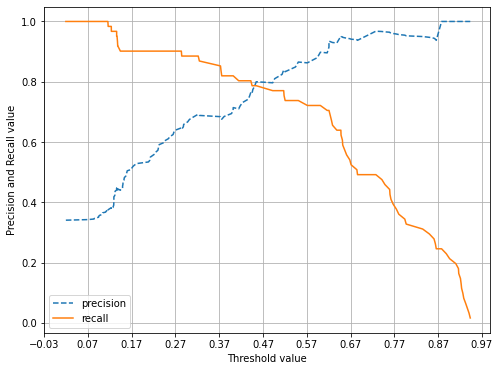

In [ ]:
# 정밀도와 재현율 곡선 시각화하기
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )

# 임곗값을 계속 증가시킬수록 재현율 값이 낮아지고 정밀도 값이 높아지는 반대의 양상이 된다
# 임곗값이 약 0.45 지점에서 재현율과 정밀도가 비슷해지는 모습을 보였다


In [ ]:
# 정밀도와 재현율의 맹점

# Positive 예측의 임곗값을 변경함에 따라 정밀도와 재현율의 수치가 변경된다
# 임곗값의 변경은 업무 환경에 맞게 두 개의 수치를 상호 보완할 수 있는 수준에서 적용해야 한다
# 정밀도와 재현율의 수치가 적절하게 조합돼 분류의 종합적인 성능 평가에 사용될 수 있는 평가 지표가 필요하다

In [ ]:
# F1 스코어
# 정밀도와 재현율을 결합한 지표
# 정밀도와 재현율이 어느 한쪽으로 치우치지 않는 수치를 나타낼 떄 상대적으로 높은 값을 가진다

In [ ]:
# 학습/예측한 로지스틱 회귀 기반 타이타닉 생존자 모델의 F1 스코어 구하기

from sklearn.metrics import f1_score 
f1 = f1_score(y_test , pred)
print('F1 스코어: {0:.4f}'.format(f1))


F1 스코어: 0.7966


In [ ]:
def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    # F1 스코어 추가
    f1 = f1_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    # f1 score print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))
    print('\n')

thresholds = [0.4 , 0.45 , 0.50 , 0.55 , 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)


임곗값: 0.4
오차 행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197, F1:0.7576


임곗값: 0.45
오차 행렬
[[105  13]
 [ 13  48]]
정확도: 0.8547, 정밀도: 0.7869, 재현율: 0.7869, F1:0.7869


임곗값: 0.5
오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705, F1:0.7966


임곗값: 0.55
오차 행렬
[[111   7]
 [ 16  45]]
정확도: 0.8715, 정밀도: 0.8654, 재현율: 0.7377, F1:0.7965


임곗값: 0.6
오차 행렬
[[113   5]
 [ 17  44]]
정확도: 0.8771, 정밀도: 0.8980, 재현율: 0.7213, F1:0.8000




In [ ]:
# ROC 곡선과 AUC
# ROC 곡선과 이에 기반한 AUC 스코어는 이진 분류의 예측 성능 측정에서 중요하게 사용되는 지표

# ROC(Receiver Operation Characteristic Curve)은 우리말로 수신자 판단 곡선
# ROC 곡선은 FPR(False Positive Rate)이 변할 때 TPR(True Positive Rate)이 어떻게 변화는지를 나타내는 곡선

# TPR은 재현율(민감도)을 나타낸다
# 예시: 질병이 있는 사람은 질병이 있는 것으로 양성 판정하는 것

# TNR은 특이성을 나타낸다 (민감도에 대응하는 지표)
# 예시: TNR은 질병이 없는 건강한 사람을 질병이 없는 것으로 음성 판정하는 것

# FPR은 1 - TNR 또는 1 - 특이성으로 표현



In [ ]:
# roc_curve () API를 이용해 타이타닉 생존자 예측 모델의 FPR, TPR,

from sklearn.metrics import roc_curve

# 레이블 값이 1일때의 예측 확률을 추출 
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1] 

fprs , tprs , thresholds = roc_curve(y_test, pred_proba_class1)

# 반환된 임곗값 배열에서 샘플로 데이터를 추출하되, 임곗값을 5 Step으로 추출. 
# thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값: ', np.round(thresholds[thr_index], 2))

# 5 step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))


샘플 추출을 위한 임곗값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46]
샘플 index로 추출한 임곗값:  [0.94 0.73 0.62 0.52 0.44 0.28 0.15 0.14 0.13 0.12]
샘플 임곗값별 FPR:  [0.    0.008 0.025 0.076 0.127 0.254 0.576 0.61  0.746 0.847]
샘플 임곗값별 TPR:  [0.016 0.492 0.705 0.738 0.803 0.885 0.902 0.951 0.967 1.   ]


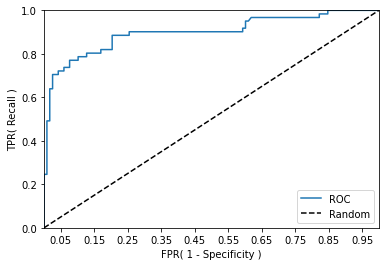

In [ ]:
def roc_curve_plot(y_test , pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음. 
    fprs , tprs , thresholds = roc_curve(y_test ,pred_proba_c1)

    # ROC Curve를 plot 곡선으로 그림. 
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림. 
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 Scale을 0.1 단위로 변경, X,Y 축명 설정등   
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Specificity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()
    
roc_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1] )

# AUC(Area Under Curve)
# ROC 곡선 밑의 면적을 구한 것으로서, 일반적으로 1에 가까울수록 좋은 수치


In [ ]:
# ROC AUC 값 구하기

from sklearn.metrics import roc_auc_score
pred_proba = lr_clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

# AUC 수치가 커지려면 FPR이 작은 상태에서 얼마나 큰 TPR을 얻을 수 있는지가 관건이다


In [ ]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
          F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
